# Generative Adversarial Networks 
### Week-9
### Case-1

### Demonstration how to generate images of handwritten digits (like MNIST dataset) using
### a Deep Convolutional Generative Adversarial Network (DCGAN)

[source](https://arxiv.org/pdf/1511.06434.pdf)

![sample output](https://tensorflow.org/images/gan/dcgan.gif)

##### (GANs) can be described as models which are trained simultaneously by an adversarial process. 
A *generator* learns to create images that look real, while a *discriminator* learns to tell real images apart from fakes.
During training, the *generator* progressively becomes better at creating images that look real, while the *discriminator becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.

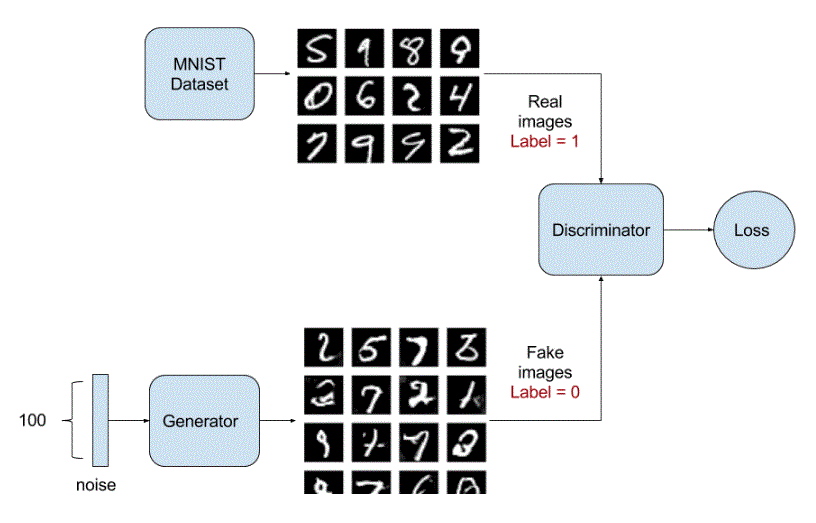

##### This notebook uses on the MNIST dataset. The following animation shows a series of images produced by the *generator* as it was trained for 50 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.

### Import 

image.png


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

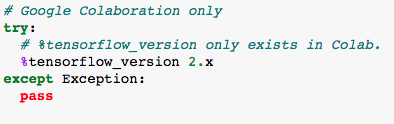

In [4]:
# Google Colaboration only
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

image.png

In [5]:
import tensorflow as tf

image.png

In [6]:
tf.__version__

'2.11.0'

In [ ]:
# You should not do the next cell code for Google Colab !

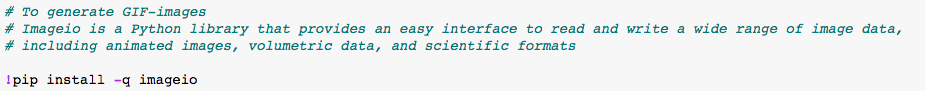

In [7]:
# To generate GIF-images
# Imageio is a Python library that provides an easy interface to read and write a wide range of image data,
# including animated images, volumetric data, and scientific formats

!pip install -q imageio

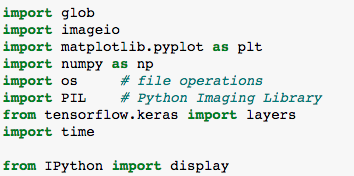


In [8]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os # file operations
import PIL # Python Imaging Library
from tensorflow.keras import layers
import time
from IPython import display

### MNIST Dataset
After treining the generator will generate handwritten digits resembling the MNIST data.


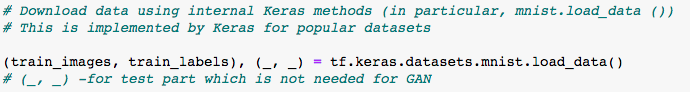

In [9]:
# Download data using internal Keras methods (in particular, mnist.load_data())
# This is implemented by Keras for popular datasets
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
# (_, _) -for test part which is not needed for GAN

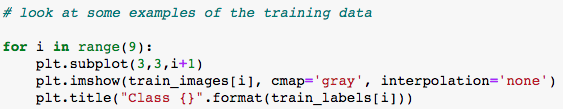

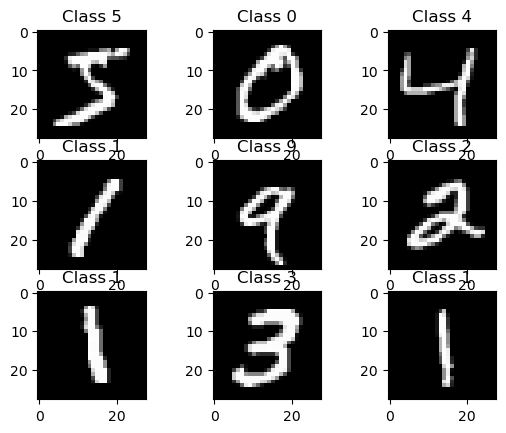

In [10]:
# look at some examples of the training data

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(train_images[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(train_labels[i]))

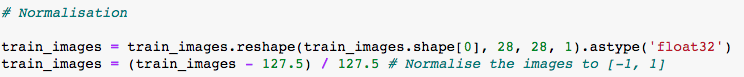

In [11]:
# Normalisation
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalise the images to [-1, 1]

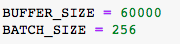

In [12]:
BUFFER_SIZE = 6000
BATCH_SIZE = 256

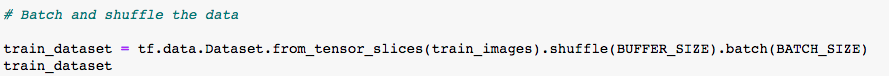

In [13]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

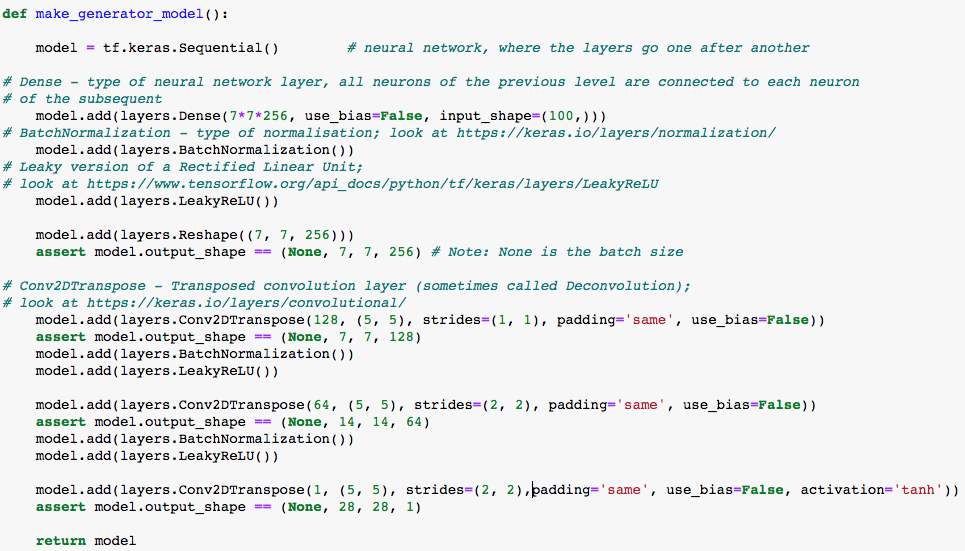


In [29]:
import tensorflow as tf
from tensorflow.keras import layers

def make_generator_model():
    model = tf.keras.Sequential() # neural network, where the layers go one after another 
    
    # Dense - type of neural network layer, all neurons of the previous level are connected to each neuron
    # of the subsequent 
    # Leaky version of Rectified Linear Unit;
    # look at https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # BatchNormalization - type of normalization; look at https://keras.io/layers/normalization/
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)
    
    #Conv2DTranspose - Transposed convolution layer (sometimes called Deconvolution);
    # look at https://keras,io/layers/convolutional/
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

In [30]:
# Create an instance of the generator model
generator = make_generator_model()

# Display the architecture of the generator model
generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_6 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_7 (Batc  (None, 7, 7, 128)       

Use the generator to create an image.


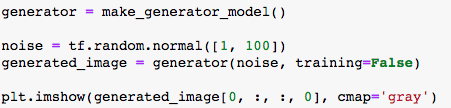



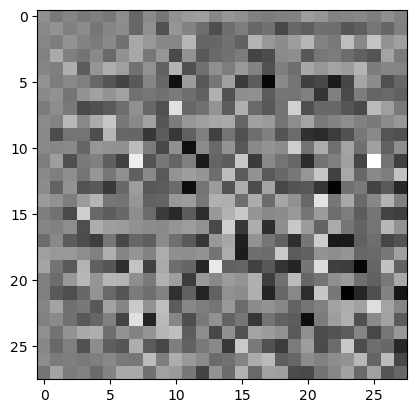

In [17]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
# Describe why the image does not have a structure?

image.png



In [18]:
generator?

### The Discriminator

The discriminator is a CNN-based image classifier.

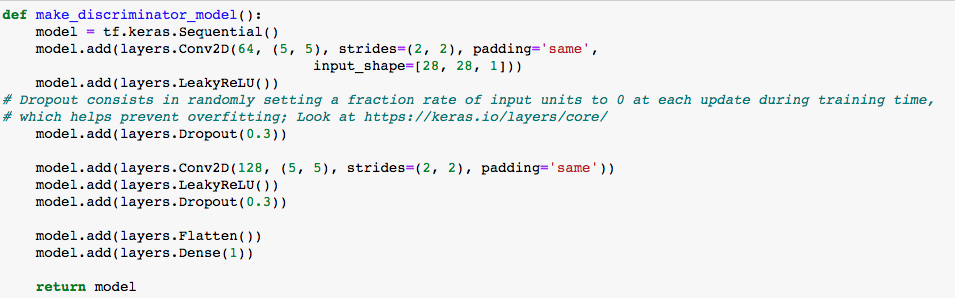

In [19]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2, 2), padding='same',
                                    input_shape=[28, 28, 1]))
    
    model.add(layers.LeakyReLU())
# Dropout consists in randomly setting a fraction rate of input units to 0 at each update during traning time,
# which helps prevent overfitting; Look at https://keras.io/layers/core/
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

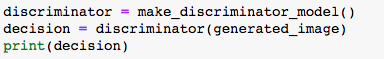

In [20]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00087858]], shape=(1, 1), dtype=float32)


image.png

In [21]:
discriminator?

## Define the loss and optimizers

Define loss functions and optimizers for both models.


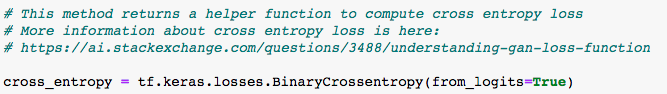

In [22]:
# This method returns a helper function to compute cross entropy loss
# More information about cross entropy loss is here
# https://ai.stackexchange.com/questions/3488/understanding-gan-loss-function

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

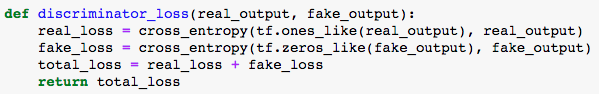

In [23]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

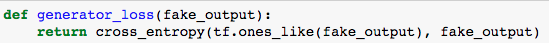

In [24]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

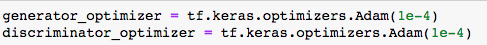

In [26]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

image.png

In [27]:
tf.keras.optimizers.Adam?

### Save checkpoints
It is useful in case a long running training task is interrupted.


image.png

In [28]:
tf.train.Checkpoint?

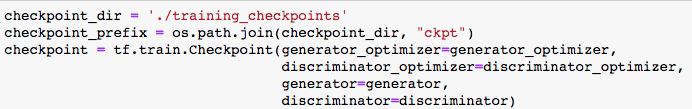

In [31]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

## Training loop



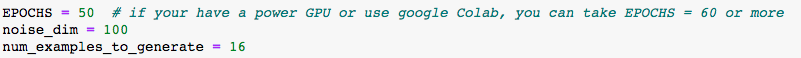


In [32]:
EPOCHS = 50 # if you have a power GPU or use google Colab, you can take EPOCHS = 60 or more
noise_dim = 100
num_examples_to_generate = 16

image.png

In [33]:
tf.random.normal?

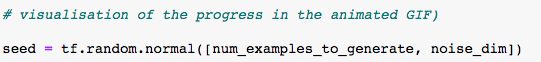

In [34]:
# visualisation of the progress in the animated GIF)

seed = tf.random.normal([num_examples_to_generate, noise_dim])

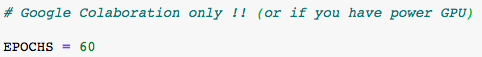

In [ ]:
# Google Colaboration only !! (or if you have power GPU)

EPOCHS = 60

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

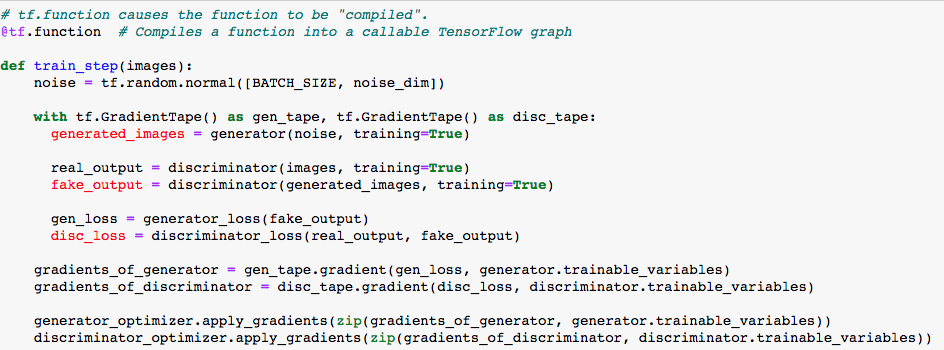

In [36]:
# tf.function causes the function to be "compiled".
@tf.function # Compiles a function into a callable TensorFlow graph

def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientType() as gen_trape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_graidents(zip(gradients_of_discriminator, discriminator.trainable_variables))

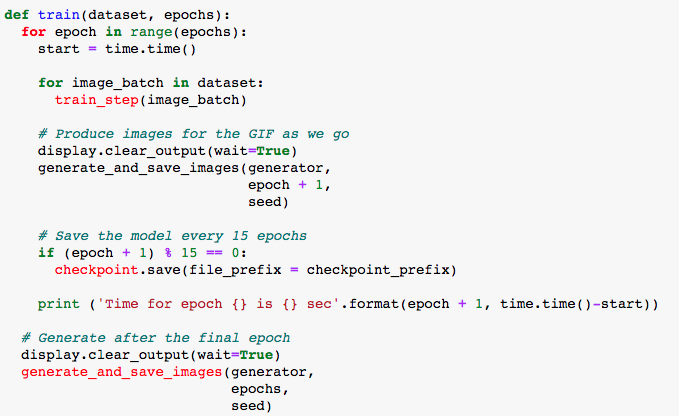

In [37]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
            
        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                epoch + 1,
                                seed)
        
        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                            epochs,
                            seed)

**Generate and save images**



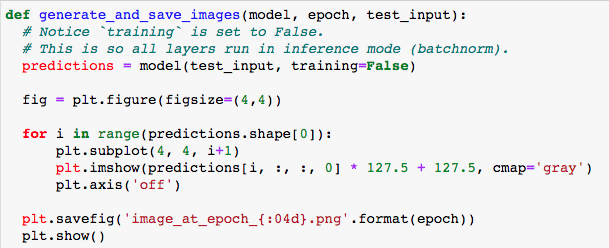

In [38]:
def generate_and_save_images(model, epoch, test_input):
    # Notice 'training' is set to False.
    # This is so all layers run in interference mode (batchnorm).
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    plt.savefig('image_at_epoch{:04d}.png'. format(epoch))
    plt.show()

## Train the model
train() - training the generator and discriminator simultaneously. 
It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits.

In [ ]:
# Save your Jupyter Notebook before start the next cell

image.png

In [ ]:
train(train_dataset, EPOCHS)

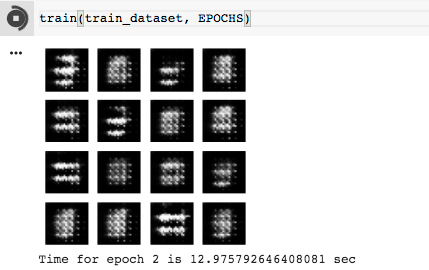

image.png

In [40]:
checkpoint.restore?

Restore the latest checkpoint.

image.png

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Show the result as a GIF-file


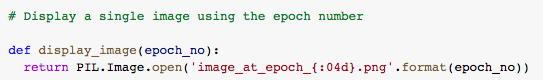

In [41]:
# Display a single image using the epoch number

def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch{:04d}.png'.format(epoch_no))

image.png

In [ ]:
display_image(EPOCHS)

In [ ]:
# describe the results

Use `imageio` to create an animated gif using the images saved during training.

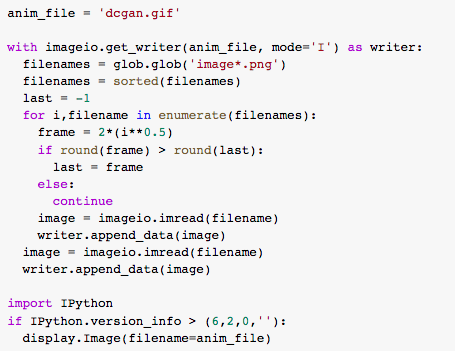

In [43]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)
        
    import IPython
    if IPython.version_info > (6,2,0,''):
        display.Image(filename=anim_file)

If you're working in Colab you can download the animation with the code below:

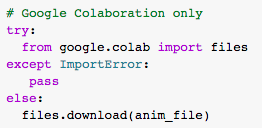

In [ ]:
# Google Colaboration only
try:
    from google.colab import files
    except ImportError:
        pass
    else:
        files.download(anim_file)

# Lab Logbook requirement:


## You should copy a screenshot of the GAN training result at a specific epoch to your logbook. The screenshot must contain the digital images, the epoch number and the time spent training for this epoch.
### Determine this epoch number using the following method:
### Take the last two digits from your SID. If this number is less than or equal to 50, it is the required epoch number. If this number is 50 or less, it becomes the required epoch number. If it exceeds 50, divide it by 50 and round up if necessary. For example, if your SID is 2187467, and the last two digits are 67, which is greater than 50. Divide by 50, resulting in 33.5. Round up to 34, and this becomes your epoch number.

In [44]:
import time
from PIL import ImageGrab

# Train your GAN model for 40 epochs
EPOCHS = 40

for epoch in range(1, EPOCHS + 1):
    start_time = time.time()
    
    # Train your GAN model for one epoch
    
    # Calculate the time spent training for this epoch
    time_spent = time.time() - start_time
    
    # Check if it's epoch 40
    if epoch == 40:
        # Capture a screenshot of the training result
        screenshot = ImageGrab.grab()  # You might need to adjust this depending on your OS and display setup
        # Save the screenshot to a file
        screenshot.save("training_result_epoch_40.png")
        
        # Save the screenshot along with the epoch number and time spent training to your logbook
        # You can implement this part according to your logbook format
        
    print(f"Epoch {epoch}/{EPOCHS}, Time spent: {time_spent:.2f} seconds")

print("Training complete.")

Epoch 1/40, Time spent: 0.00 seconds
Epoch 2/40, Time spent: 0.00 seconds
Epoch 3/40, Time spent: 0.00 seconds
Epoch 4/40, Time spent: 0.00 seconds
Epoch 5/40, Time spent: 0.00 seconds
Epoch 6/40, Time spent: 0.00 seconds
Epoch 7/40, Time spent: 0.00 seconds
Epoch 8/40, Time spent: 0.00 seconds
Epoch 9/40, Time spent: 0.00 seconds
Epoch 10/40, Time spent: 0.00 seconds
Epoch 11/40, Time spent: 0.00 seconds
Epoch 12/40, Time spent: 0.00 seconds
Epoch 13/40, Time spent: 0.00 seconds
Epoch 14/40, Time spent: 0.00 seconds
Epoch 15/40, Time spent: 0.00 seconds
Epoch 16/40, Time spent: 0.00 seconds
Epoch 17/40, Time spent: 0.00 seconds
Epoch 18/40, Time spent: 0.00 seconds
Epoch 19/40, Time spent: 0.00 seconds
Epoch 20/40, Time spent: 0.00 seconds
Epoch 21/40, Time spent: 0.00 seconds
Epoch 22/40, Time spent: 0.00 seconds
Epoch 23/40, Time spent: 0.00 seconds
Epoch 24/40, Time spent: 0.00 seconds
Epoch 25/40, Time spent: 0.00 seconds
Epoch 26/40, Time spent: 0.00 seconds
Epoch 27/40, Time spe